In [1]:
import torch
pt_version = torch.__version__
print(pt_version)

2.0.1


In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples sequences: ",  len(list(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7fb2f0784e50>
Number of samples sequences:  34249


- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression

tensor([[ 0.3724,  0.2452,  0.4961,  ...,  0.3909,  0.4761,  0.5641],
        [ 0.6631,  0.4486,  0.6631,  ...,  0.4157,  0.5201,  0.4651],
        [ 0.2425,  0.6026,  0.0693,  ...,  0.4218,  0.5311,  0.7620],
        ...,
        [-0.0235, -0.0517,  0.0322,  ...,  0.3352,  0.4267,  0.4157],
        [ 0.8115,  0.6246,  0.6754,  ...,  0.8115,  0.6796,  0.5208],
        [ 0.4899,  0.4321,  0.2363,  ...,  0.2301,  0.4651,  0.3538]])
tensor([[  0,   0,   0,  ..., 206, 206, 206],
        [  0,  13,  37,  ..., 187, 198, 206]])
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])
tensor([[ 0.2452,  0.4961,  0.6521,  ...,  0.4761,  0.5641, -0.0022],
        [ 0.4486,  0.6631,  0.5916,  ...,  0.5201,  0.4651,  0.6026],
        [ 0.6026,  0.0693,  0.7180,  ...,  0.5311,  0.7620,  0.5311],
        ...,
        [-0.0517,  0.0322,  0.3717,  ...,  0.4267,  0.4157,  0.5641],
        [ 0.6246,  0.6754,  0.7235,  ...,  0.6796,  0.5208,  0.4596],
        [ 0.4321,  0.2363,  0.3882, 

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

<AxesSubplot:>

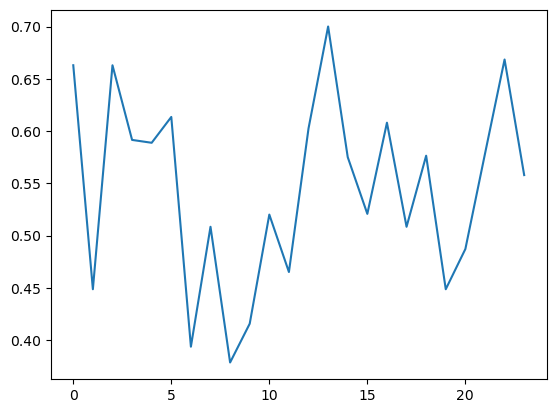

In [5]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [6]:
from torch_geometric_temporal.signal import temporal_signal_split
#from torch.utils.data import DataLoader
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.9)

print("Number of train buckets: ", len(list(train_dataset)))
#print(list(train_dataset))
print("Number of test buckets: ", len(list(test_dataset)))
print([train_dataset])

Number of train buckets:  30824
Number of test buckets:  3425


In [7]:
device = torch.device('cuda') 

train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)


test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)

In [8]:
#train_loader = DataLoader(list(train_dataset), batch_size=300,shuffle =True)
#test_loader = DataLoader(list(test_dataset), batch_size=300,shuffle =True)

In [8]:
import torch
import torch.nn.functional as F
from model.lstm_gat_gcn import LSTMGATGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super().__init__()
        self.tgnn = LSTMGATGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):

        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

net = TemporalGNN(node_features=2, periods=12)
print(net)

TemporalGNN(
  (tgnn): LSTMGATGCN(
    (_base_lstm_gcn): LSTMGCN(
      (conv_i): GCNConv(2, 64)
      (linear_i): Linear(in_features=128, out_features=64, bias=True)
      (conv_f): GCNConv(2, 64)
      (linear_f): Linear(in_features=128, out_features=64, bias=True)
      (conv_o): GCNConv(2, 64)
      (linear_o): Linear(in_features=128, out_features=64, bias=True)
      (conv_c_t): GCNConv(2, 64)
      (linear_c_t): Linear(in_features=128, out_features=64, bias=True)
      (conv_c): GCNConv(2, 64)
    )
    (_gat_layer): GATConv(64, 32, heads=1)
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)


In [45]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):

        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

net = TemporalGNN(node_features=2, periods=12)
print(net)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)


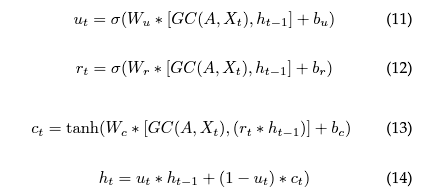

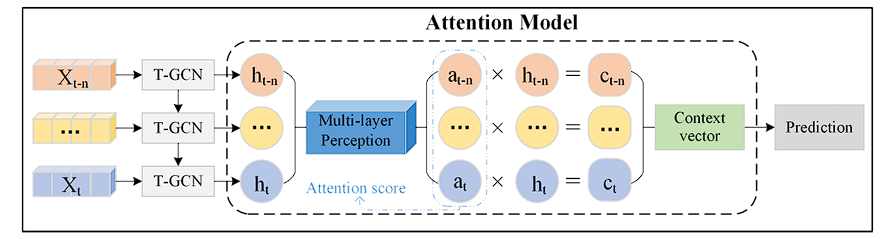

In [7]:
import torch
import torch.nn.functional as F
from model.latgcn import LATGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super().__init__()
        self.tgnn = LATGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):

        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

net = TemporalGNN(node_features=2, periods=12)
print(net)

TemporalGNN(
  (tgnn): LATGCN(
    (_base_lstm_gcn): LSTMGCN(
      (conv_i): GCNConv(2, 32)
      (linear_i): Linear(in_features=64, out_features=32, bias=True)
      (conv_f): GCNConv(2, 32)
      (linear_f): Linear(in_features=64, out_features=32, bias=True)
      (conv_o): GCNConv(2, 32)
      (linear_o): Linear(in_features=64, out_features=32, bias=True)
      (conv_c_t): GCNConv(2, 32)
      (linear_c_t): Linear(in_features=64, out_features=32, bias=True)
      (conv_c): GCNConv(2, 32)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)


In [9]:
def shuffle_static_graph_temporal_signal(dataset):
    num_samples = len(list(dataset))
    shuffled_indices = np.random.permutation(num_samples)
    shuffled_dataset = [dataset[i] for i in shuffled_indices]

    return shuffled_dataset

In [12]:
from tqdm import tqdm
import torch.nn
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
edge_index = train_dataset[0].edge_index.to(device)

train_loss=[]
test_loss=[]
accu=[]
predictions = []
labels = []

def train(train_loader,test_loader,model,optimizer,edge_index):
    #set train mode
    model.train()
    print("Running training on ",device)
    num_batches = len(train_loader)
    #train
    total_loss=0
    for batch,(X,Y) in tqdm(enumerate(train_loader)): 
        loss = 0
        step = 0
        #print(data)
        
        #forward
        for x,y in zip(X,Y):
            #print(snapshot)
            y_hat = model(x, edge_index)
            l = torch.nn.MSELoss()
            loss = loss + l(y_hat,y)
            step += 1
            
        #backward
        loss = loss / (step + 1)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        
        if (batch+1)%10 ==0 :
            print("average Batch {} train MSE: {:.4f}".format(batch, loss.item()))
            test(test_loader, device,model,edge_index)

In [13]:
def test(test_loader,device,model,edge_index):
    model.eval()
    horizon = 288
    total_loss=0 
    avg_loss=0
    acc = 0
    size = len(list(test_dataset))
    num_batches = len(test_loader)

    with torch.no_grad():
        for (X,Y) in test_loader:
            
            loss = 0
            step = 0
            
            #test
            for x,y in zip(X,Y):
                #compare label and prediction
                y_hat = model(x, edge_index)
                loss = loss + torch.mean((y_hat-y)**2)
                labels.append(y)
                predictions.append(y_hat)
                step += 1

            loss = loss / (step+1)
            loss = loss.item()
            total_loss+=loss
        
        #caculate average loss
        avg_loss = total_loss/num_batches
        
        print("average Test MSE: {:.4f}".format(avg_loss))
        test_loss.append(avg_loss)

In [ ]:
batch_size = 600
epochs = 20
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=True,drop_last=True)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader,test_loader, model, optimizer,edge_index)

torch.save(model,"lstgatgcn_pth")
torch.save(model.state_dict,"lstgatgcn_w.pth")

import matplotlib.pyplot as plt 
batch_num_train = range(0,len(train_loss))
batch_num_test = range(0,len(test_loss)*10,10)

plt.plot(batch_num_train,train_loss , '-', linewidth=1.0, color='g')
plt.plot(batch_num_test,test_loss , '-', linewidth=1.0, color='b')
plt.legend(['train_loss','test_loss'], fontsize=10)
plt.show()


Epoch 1
-------------------------------
Running training on  cuda


9it [02:19, 15.32s/it]

average Batch 9 train MSE: 0.4964


10it [03:21, 29.66s/it]

average Test MSE: 0.6227


19it [05:46, 16.18s/it]

average Batch 19 train MSE: 0.4943


20it [06:49, 30.06s/it]

average Test MSE: 0.6233


29it [09:11, 17.03s/it]

average Batch 29 train MSE: 0.5186


30it [10:14, 30.88s/it]

average Test MSE: 0.6212


39it [12:36, 16.23s/it]

average Batch 39 train MSE: 0.4886


40it [13:39, 30.09s/it]

average Test MSE: 0.6220


43it [14:25, 20.47s/it]

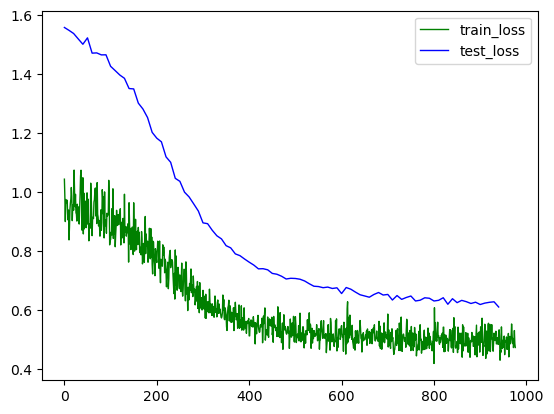

In [51]:
import matplotlib.pyplot as plt 
batch_num_train = range(0,977)
batch_num_test = range(0,950,10)

plt.plot(batch_num_train,train_loss[:977] , '-', linewidth=1.0, color='g')
plt.plot(batch_num_test,test_loss[:95] , '-', linewidth=1.0, color='b')
plt.legend(['train_loss','test_loss'], fontsize=10)
plt.show()


In [18]:
model.eval()

predictions = []
labels = []
with torch.no_grad():
    for snapshot in test_dataset:
        snapshot = snapshot.to(device)
        y_hat = model(snapshot.x, snapshot.edge_index)
        labels.append(snapshot.y)
        predictions.append(y_hat)


        
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (3425,)


95


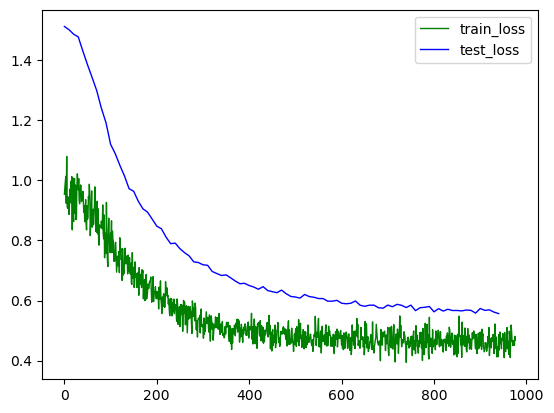

In [22]:
import matplotlib.pyplot as plt 
batch_num_train = range(0,len(train_loss))
print(len(test_loss))
batch_num_test = range(0,len(test_loss)*10,10)

plt.plot(batch_num_train,train_loss , '-', linewidth=1.0, color='g')
plt.plot(batch_num_test,test_loss , '-', linewidth=1.0, color='b')
plt.legend(['train_loss','test_loss'], fontsize=10)
plt.show()

In [50]:
print(len(train_loss))
print(len(test_loss))

1277
125


In [44]:
import torch
torch.save(model,"lstgcn.pth")
torch.save(model.state_dict,"lstgcn_w.pth")

In [33]:
print(preds)
print(labs)

[0.19567621 0.3005359  0.30588338 ... 0.3758598  0.38402122 0.38670534]
[0.79294604 0.79294604 0.72490996 ... 0.74002916 0.7620205  0.7620205 ]


Text(0, 0.5, 'speed')

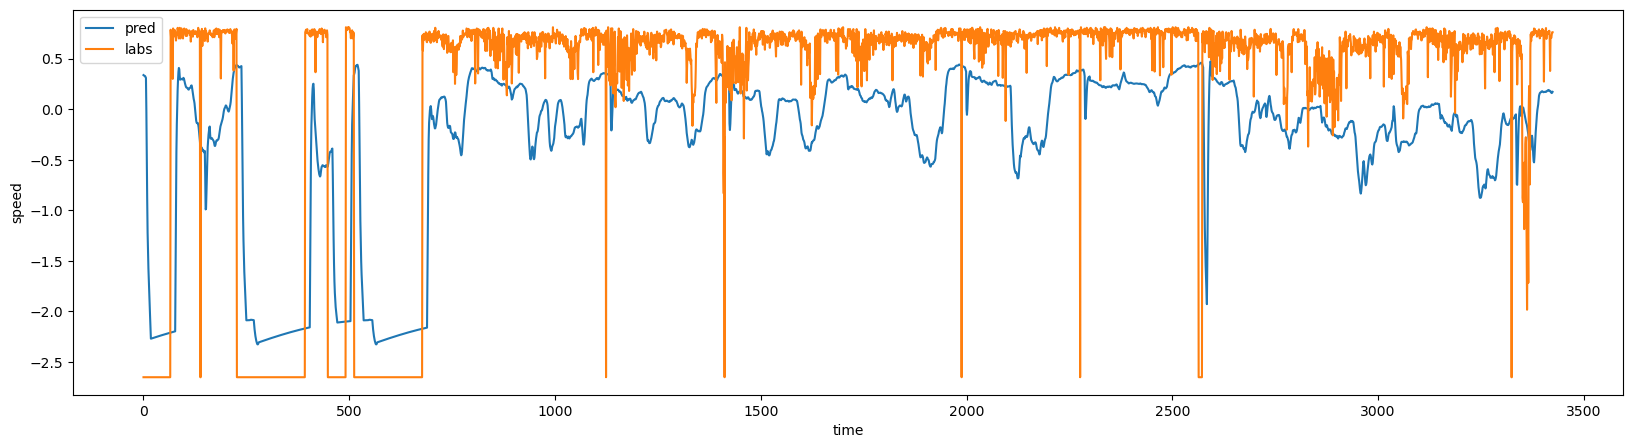

In [19]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="labs")
plt.xlabel("time")
plt.ylabel("speed")